Using Apple Metal Performance Shaders (MPS)
Device: mps
Model created with 1153 parameters
Model device: mps:0

--- Training PINN ---
Interior collocation points: 500
Boundary enforcement points: 10
Total parameters: 1153


Training PINN:   0%|                                                      | 0/15000 [00:00<?, ?it/s]

Training PINN: 100%|█| 15000/15000 [01:55<00:00, 129.75it/s, Loss=1.17e-02, PDE=1.04e-02, BC=1.32e-0



🎉 Training completed!


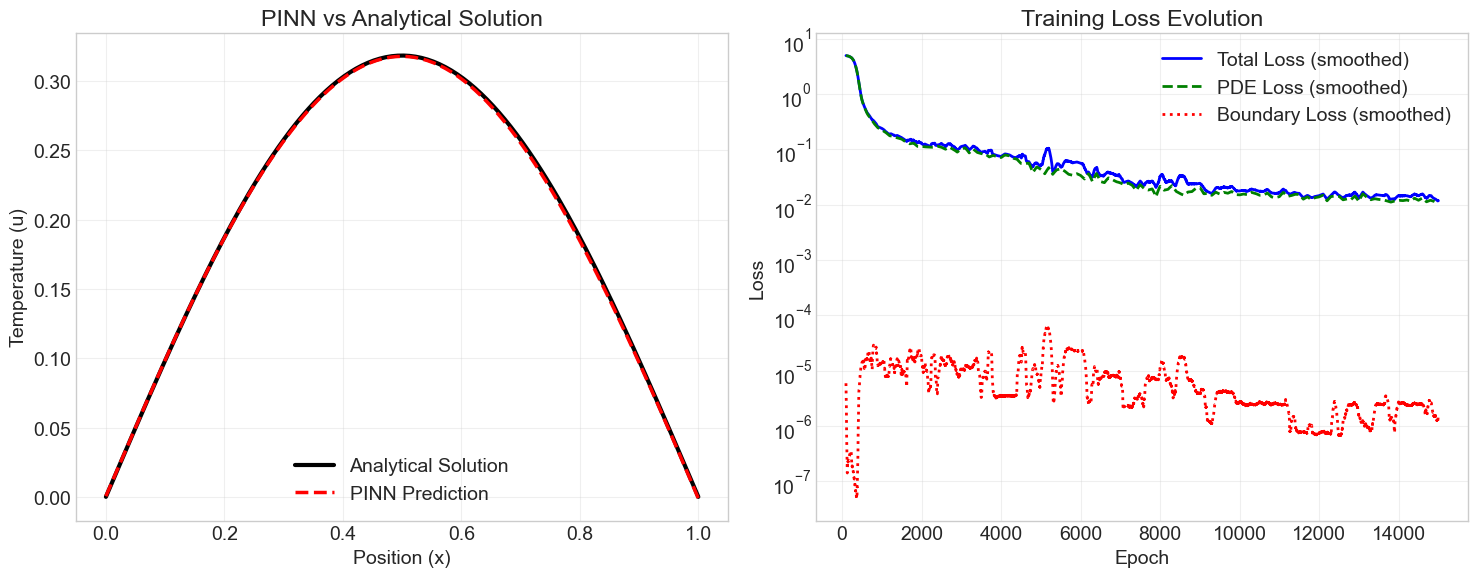


=== PINN Performance Metrics ===
Maximum absolute error: 2.50e-03
Mean absolute error: 1.07e-03
Root Mean Square Error: 1.29e-03
Final total loss: 1.17e-02
Final PDE loss: 1.04e-02
Final boundary loss: 1.32e-06

=== Boundary Condition Check ===
u(0) = 4.67e-04 (should be 0)
u(1) = -1.15e-03 (should be 0)

=== Device Information ===
Device used: mps


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set up plot styles
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14, 'figure.figsize': (10, 6)})

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for available device (CUDA, MPS, or CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA GPU: {torch.cuda.get_device_name()}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Metal Performance Shaders (MPS)")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"Device: {device}")

# -----------------------------------------------------------------------------
# 1. Define the Physics-Informed Neural Network
# -----------------------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1, num_layers=3):
        super(PINN, self).__init__()
        
        # Build the network layers - smaller network for better training
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.Tanh())
        
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_size, output_size))
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights with smaller values
        self.init_weights()
    
    def init_weights(self):
        """Initialize weights using Xavier initialization with small scaling"""
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)  # Smaller initial weights
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.network(x)

# -----------------------------------------------------------------------------
# 2. Define Loss Functions
# -----------------------------------------------------------------------------
def pde_loss(model, x_interior):
    """
    Compute the PDE residual loss for: d²u/dx² + πsin(πx) = 0
    """
    x_interior.requires_grad_(True)
    
    # Forward pass
    u = model(x_interior)
    
    # Compute first derivative
    du_dx = torch.autograd.grad(
        outputs=u,
        inputs=x_interior,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # Compute second derivative
    d2u_dx2 = torch.autograd.grad(
        outputs=du_dx,
        inputs=x_interior,
        grad_outputs=torch.ones_like(du_dx),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # PDE residual: d²u/dx² + π sin(πx) = 0
    forcing_term = torch.pi * torch.sin(torch.pi * x_interior)
    pde_residual = d2u_dx2 + forcing_term
    
    return torch.mean(pde_residual**2)

def boundary_loss(model, x_boundary):
    """
    Compute boundary condition loss: u(0) = 0, u(1) = 0
    """
    u_boundary = model(x_boundary)
    return torch.mean(u_boundary**2)

# -----------------------------------------------------------------------------
# 3. Training Function
# -----------------------------------------------------------------------------
def train_pinn(model, epochs=20000, lr=0.001):
    """
    Train the PINN using physics loss and boundary conditions
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=1000)
    
    # Generate collocation points for PDE residual (interior points)
    n_interior = 500
    n_boundary = 10  # More boundary points for better BC enforcement
    
    print(f"\n--- Training PINN ---")
    print(f"Interior collocation points: {n_interior}")
    print(f"Boundary enforcement points: {n_boundary}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
    
    losses = {'total': [], 'pde': [], 'boundary': []}
    
    # Create progress bar
    pbar = tqdm(range(epochs), desc="Training PINN", ncols=100)
    
    for epoch in pbar:
        optimizer.zero_grad()
        
        # Regenerate collocation points every few epochs for better coverage
        if epoch % 100 == 0:
            x_interior = torch.rand(n_interior, 1, device=device) * 0.98 + 0.01
            x_boundary = torch.cat([
                torch.zeros(n_boundary//2, 1, device=device),
                torch.ones(n_boundary//2, 1, device=device)
            ])
        
        # Compute PDE residual loss
        loss_pde = pde_loss(model, x_interior)
        
        # Compute boundary condition loss
        loss_bc = boundary_loss(model, x_boundary)
        
        # Total loss with adaptive weighting
        lambda_bc = 1000.0  # Higher weight for boundary conditions
        total_loss = loss_pde + lambda_bc * loss_bc
        
        # Backward pass and optimization
        total_loss.backward()
        
        # Gradient clipping to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step(total_loss)
        
        # Store losses
        losses['total'].append(total_loss.item())
        losses['pde'].append(loss_pde.item())
        losses['boundary'].append(loss_bc.item())
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{total_loss.item():.2e}',
            'PDE': f'{loss_pde.item():.2e}',
            'BC': f'{loss_bc.item():.2e}'
        })
    
    pbar.close()
    return model, losses

# -----------------------------------------------------------------------------
# 4. Analytical Solution for Comparison
# -----------------------------------------------------------------------------
def analytical_solution(x):
    """Analytical solution: u(x) = (1/π)sin(πx)"""
    return (1 / (np.pi)) * np.sin(np.pi * x)

# -----------------------------------------------------------------------------
# 5. Main Training and Visualization
# -----------------------------------------------------------------------------
def main():
    # Create the PINN model - smaller network for better convergence
    model = PINN(input_size=1, hidden_size=32, output_size=1, num_layers=3).to(device)
    
    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
    print(f"Model device: {next(model.parameters()).device}")
    
    # Train the model with lower learning rate
    trained_model, losses = train_pinn(model, epochs=15000, lr=0.0005)
    
    print("\n🎉 Training completed!")
    
    # Generate test points for visualization
    x_test = torch.linspace(0, 1, 200, device=device).reshape(-1, 1)
    
    # Get predictions
    trained_model.eval()
    with torch.no_grad():
        u_pred = trained_model(x_test).cpu().numpy()
    
    # Convert to numpy for plotting
    x_test_np = x_test.cpu().numpy()
    u_true = analytical_solution(x_test_np)
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Solution comparison
    ax1.plot(x_test_np, u_true, 'k-', label='Analytical Solution', linewidth=3)
    ax1.plot(x_test_np, u_pred, 'r--', label='PINN Prediction', linewidth=2.5)
    ax1.set_xlabel('Position (x)')
    ax1.set_ylabel('Temperature (u)')
    ax1.set_title('PINN vs Analytical Solution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Training losses (smoothed for better visualization)
    epochs = range(1, len(losses['total']) + 1)
    # Apply smoothing to reduce noise in loss plots
    window = 100
    if len(losses['total']) > window:
        total_smooth = np.convolve(losses['total'], np.ones(window)/window, mode='valid')
        pde_smooth = np.convolve(losses['pde'], np.ones(window)/window, mode='valid')
        boundary_smooth = np.convolve(losses['boundary'], np.ones(window)/window, mode='valid')
        epochs_smooth = range(window, len(losses['total']) + 1)
        
        ax2.semilogy(epochs_smooth, total_smooth, 'b-', label='Total Loss (smoothed)', linewidth=2)
        ax2.semilogy(epochs_smooth, pde_smooth, 'g--', label='PDE Loss (smoothed)', linewidth=2)
        ax2.semilogy(epochs_smooth, boundary_smooth, 'r:', label='Boundary Loss (smoothed)', linewidth=2)
    else:
        ax2.semilogy(epochs, losses['total'], 'b-', label='Total Loss', linewidth=2)
        ax2.semilogy(epochs, losses['pde'], 'g--', label='PDE Loss', linewidth=2)
        ax2.semilogy(epochs, losses['boundary'], 'r:', label='Boundary Loss', linewidth=2)
    
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training Loss Evolution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Compute and print error metrics
    error = np.abs(u_pred.flatten() - u_true.flatten())
    max_error = np.max(error)
    mean_error = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    
    print("\n=== PINN Performance Metrics ===")
    print(f"Maximum absolute error: {max_error:.2e}")
    print(f"Mean absolute error: {mean_error:.2e}")
    print(f"Root Mean Square Error: {rmse:.2e}")
    print(f"Final total loss: {losses['total'][-1]:.2e}")
    print(f"Final PDE loss: {losses['pde'][-1]:.2e}")
    print(f"Final boundary loss: {losses['boundary'][-1]:.2e}")
    
    # Test boundary conditions
    with torch.no_grad():
        u_0 = trained_model(torch.tensor([[0.0]], device=device)).item()
        u_1 = trained_model(torch.tensor([[1.0]], device=device)).item()
    
    print(f"\n=== Boundary Condition Check ===")
    print(f"u(0) = {u_0:.2e} (should be 0)")
    print(f"u(1) = {u_1:.2e} (should be 0)")
    
    # Device info summary
    print(f"\n=== Device Information ===")
    print(f"Device used: {device}")
    if device.type == 'cuda':
        print(f"GPU Memory allocated: {torch.cuda.memory_allocated(device)/1024**2:.1f} MB")
        print(f"GPU Memory cached: {torch.cuda.memory_reserved(device)/1024**2:.1f} MB")

if __name__ == "__main__":
    main()